## **Adrenal Tumor Detection and Segmentation with GA-U-KAN**   

### **1 - Image Format Conversion and Visualization** ***(This Notebook)***

- 0.0 Download Abdominal CT scans of kidneys with adrenal lesions with corresponding segmentation labels from the NIH Cancer Imaging Archive https://www.cancerimagingarchive.net/collection/adrenal-acc-ki67-seg/

- 1.0 Load the metadata of the orginal CT scans of kidneys with adrenal lesions, `../DICOM_Files/metadata.csv`

- 1.1 Convert all .DICOM stacks downloaded from NIH Cancer Imaging Archive into .NIfTI format in `../NIFTI_Files/..` for future use

- 1.2 Visualize the `Adrenal_Ki67_Seg_001` CT scan sample and its segmentation result

### **2 - Data Split** ***(This Notebook)***

- 2.1 Data preprocess, save images of the original scans and their corresponding masks in array form into `images` and `masks` 

- 2.2 Split the porcessed data into `train_input`, `train_label`, `test_input`, and `test_label`

### **3 - Finding the Best-performing U-KAN Model Structure**

- 3.1 Define operators used to implement the genetic algorithm (GA), include `Selection`, `Crossover`, `Mutation`

- 3.2 Define the U-KAN model (encoder, bottleneck, decoder) which uses Kolmogorov-Arnold Network Blocks as the bottleneck structure

- 3.3 Define the model loss function `model_loss` = `ce_loss` + `dice_loss` + `regularization_loss`

- 3.4 Use `PatchEmbed` to segment input (training/validation) images into patches and find the best U-KAN model

### **4 - More**

In [2]:
import numpy as np
import pandas as pd
import skimage

import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import nibabel
import os
import pydicom
from pydicom import dcmread
from pydicom.data import get_testdata_files
from collections import defaultdict

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.misc

from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label, regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data

import glob
from skimage.io import imread

import dicom2nifti
import pydicom
import nibabel
import os
import tqdm

## **1.0 - Set the Paths and Load the Metadata**

In [4]:
# path to the directory of the current project
work_dir = r'C:\Users\amp87\Desktop\DICOM_Files' 

# path to original DICOM dataset
dicom_path = r'C:\Users\amp87\Desktop\DICOM_Files\Adrenal-ACC-Ki67-Seg' 

# path to the converted NIFTI dataset 
target_path = r'C:\Users\amp87\Desktop\Converted\NIFTI_Files\Adrenal-ACC-Ki67-Seg'

# save the metadata in dataframe
metadata_file = r'C:\Users\amp87\Desktop\DICOM_Files\metadata.csv'
meta_df = pd.read_csv(metadata_file) 

## **1.1 - Convert All CT Scans in DICOM Format (.dcm) to NIfTI Format (.nii)**

In [6]:
def get_affine_matrix(dicom_filepath):
    ds = pydicom.dcmread(dicom_filepath)
    
    # extract necessary attributes
    if not hasattr(ds, 'PixelSpacing'):
        pixel_spacing = [1.0, 1.0] # use default
    else:
        pixel_spacing = ds.PixelSpacing  # [dr, dc]
        
    if not hasattr(ds, 'SliceThickness'):
        slice_thickness = 1.0
    else:
        slice_thickness = ds.SliceThickness  # dz
    
    if not hasattr(ds, 'ImagePositionPatient'):
        image_position = [0.0, 0.0, 0.0] # default as origin
    else:
        image_position = ds.ImagePositionPatient  # [Sx, Sy, Sz]
        
    if not hasattr(ds, 'ImageOrientationPatient'):
        image_orientation = [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]
    else:
        image_orientation = ds.ImageOrientationPatient  # [F11, F21, F31, F12, F22, F32]
    
    # split the image_orientation to form the rotation matrix components
    F11, F21, F31 = image_orientation[3:]  # row direction cosines
    F12, F22, F32 = image_orientation[:3]  # column direction cosines
    
    # spply scaling (dr for rows, dc for columns, dz for slice thickness)
    dr, dc = pixel_spacing
    dz = slice_thickness
    
    # 4x4 affine matrix
    affine_matrix = np.array([[F11 * dr, F12 * dc, 0, image_position[0]],
                              [F21 * dr, F22 * dc, 0, image_position[1]],
                              [F31 * dr, F32 * dc, dz, image_position[2]],
                              [0, 0, 0, 1]])
    
    return affine_matrix

#### Conversion Starts

In [8]:
# loop through all .DICOM files and convert them to .NIFTI
for dicom_filepath in tqdm.tqdm(glob.glob(dicom_path + r'\*\*\*\*')):
    
    # compute the length of the upper directory and the filename to extract the correct sub-sub-sub path 
    dicom_main_path_len = len(dicom_path)
    dicom_filename_len = len(os.path.basename(dicom_filepath))
    
    # read the .DICOM file and get the affine matrix
    dicom_file = pydicom.dcmread(dicom_filepath)
    affine_mat = get_affine_matrix(dicom_filepath)
    
    # the .DICOM image data
    dicom_image_data = dicom_file.pixel_array 
    
    # convert to .NIFTI files under the correct path
    nifti_img = nibabel.Nifti1Image(dicom_image_data, affine=affine_mat) 
    nifti_filename = os.path.basename(dicom_filepath)[:-4] + r'.nii'
    
    nifti_filepath = target_path + dicom_filepath[dicom_main_path_len:-dicom_filename_len] + nifti_filename
    
    # in case not in the same dir
    directory = os.path.dirname(nifti_filepath)  
    os.makedirs(directory, exist_ok=True)  
    
    nibabel.save(nifti_img, nifti_filepath)

100%|████████████████████████████████████████████████████████████████████████████| 18255/18255 [04:44<00:00, 64.26it/s]


In [9]:
# delete all .DICOM files (not necessary?) if the target and the source folders are the same
for root, dirs, files in os.walk(target_path):  
    for file in files:  
        # check whether the file is a .DICOM file
        if file.endswith(r'.dcm'):
            dicom_filepath = os.path.join(root, file)  
            # delete the used .DICOM file
            os.remove(dicom_filepath)

## **1.2 - Visualize One CT Scan Image with Its Segmentation Result**

In [11]:
# paths to the converted NIFTI dataset, in case forgot
target_path = r'C:\Users\amp87\Desktop\Converted\NIFTI_Files\Adrenal-ACC-Ki67-Seg' 

### Example of A Stack of Images Showing ABNORMAL Adrenal Glands (Adrenal_Ki67_Seg_001)

In [28]:
# sub dir of all the slices, glob the list of paths to the slices
nifti_img001_subdir = target_path + r'\Adrenal_Ki67_Seg_001\08-22-2000-NA-CT ABDOMEN-56266'
nifti_img001_slices = glob.glob(os.path.join(nifti_img001_subdir, '2.000000-Pre Abd 5.0 B40f-18492', '*'))

num_slices = len(nifti_img001_slices)

# image data for only one slice ↓ use nifti_img1[0]
nifti_img001_slice0 = nibabel.load(nifti_img001_slices[0]).get_fdata()

# get each slice's shape
slice_height, slice_width = nifti_img001_slice0.shape

In [30]:
nifti_img001_slice0.shape

(512, 512)

In [32]:
# combine the slices together to create a 3-dimensional .nii file with depth information
nifti_img001_3d = np.zeros((num_slices, slice_height, slice_width), dtype=np.float32) 

for slice_index in range(num_slices):  
    slice_data = nibabel.load(nifti_img001_slices[slice_index]).get_fdata()
    nifti_img001_3d[slice_index,:,:] = slice_data

In [33]:
nifti_img001_3d.shape

(60, 512, 512)

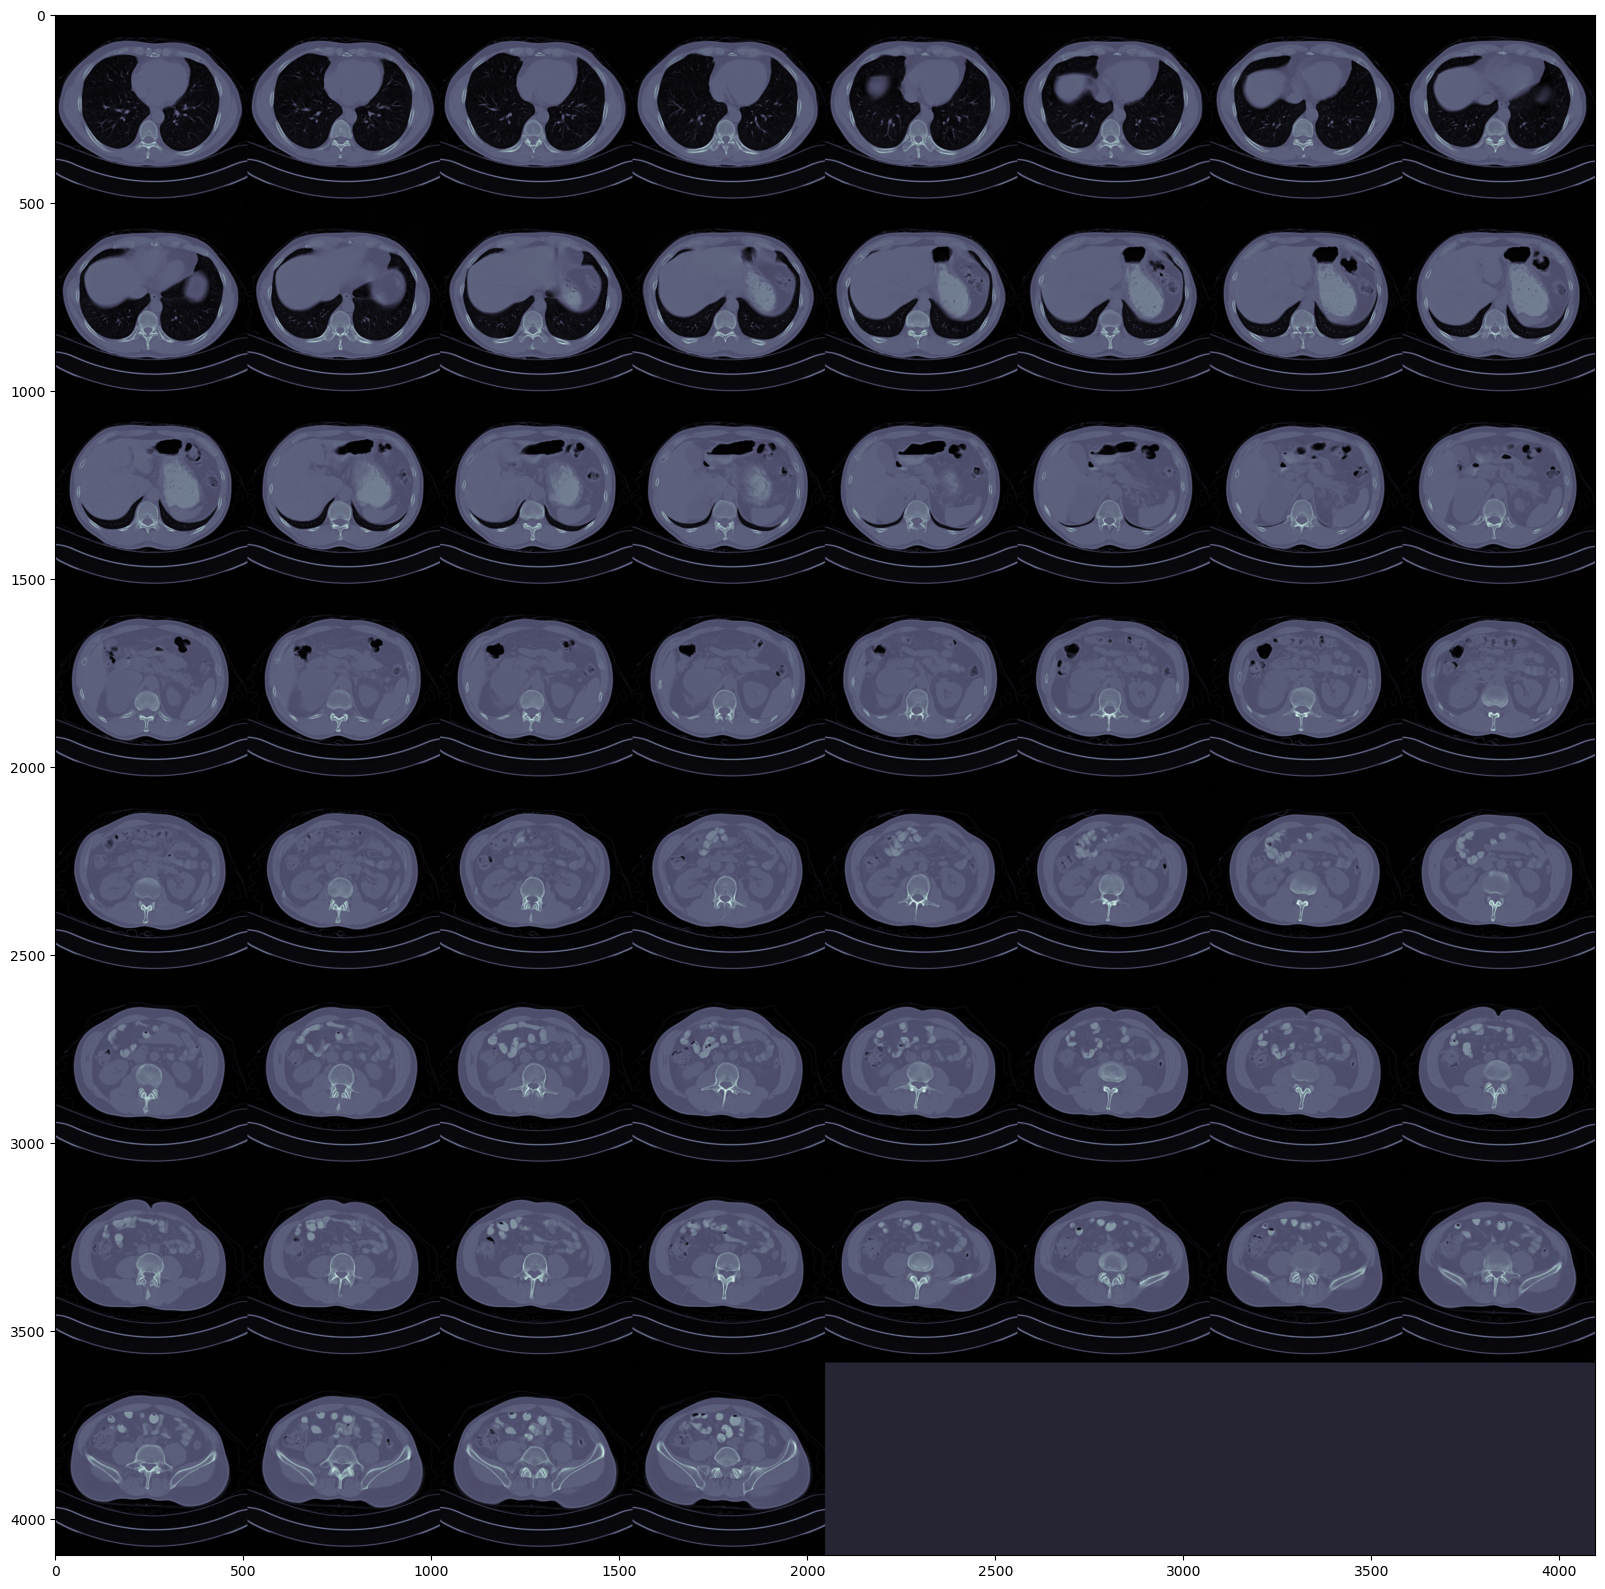

In [36]:
from skimage.util import montage  

montage_img001 = montage(nifti_img001_3d)

fig, ax1 = plt.subplots(1, 1, figsize=(20,20))
ax1.imshow(montage_img001, cmap='bone')

### See A Slice's Corresponding Segmentation Result

In [38]:
img001_seg = target_path + r'\Adrenal_Ki67_Seg_001\08-22-2000-NA-CT ABDOMEN-56266\300.000000-Segmentation-33545\1-1.nii'
img001_seg_data = nibabel.load(img001_seg).get_fdata()

In [39]:
img001_seg_data.shape

(61, 512, 512)

In [40]:
# one slice from the stack
slice30_index = 30

slice30_data = nibabel.load(nifti_img001_slices[30]).get_fdata()

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
# ax1.imshow(slice30_data)
# ax1.set_title('Slice No.30 from Sample 001\n')
# ax2.imshow(img001_seg_data[slice30_index,:,:])
# ax2.set_title('Segmentation of Slice No.30 from Sample 001\n')

Text(0.5, 1.0, 'Segmentation of Slice No.30 from Sample 001\n')

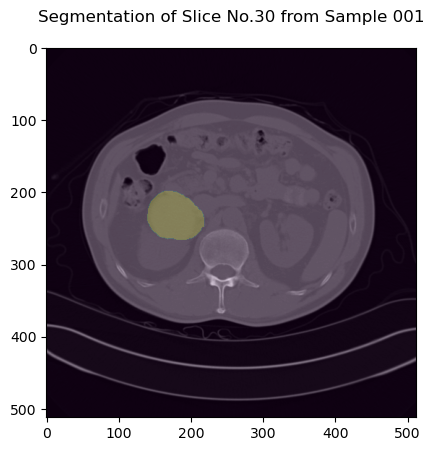

In [41]:
# rate of transparency
alpha = np.full((slice_height, slice_width), 0.5)

# tsp_slice30_seg_data = np.dstack((img001_seg_data[slice30_index,:,:], alpha.astype(np.uint8)))

fig, ax = plt.subplots()

ax.imshow(slice30_data, cmap='gray')
# ax.imshow(tsp_slice30_seg_data)
ax.imshow(img001_seg_data[slice30_index,:,:], alpha=0.2)
ax.set_title('Segmentation of Slice No.30 from Sample 001\n')

In [42]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

from kan import KAN

## **2.1 - Data Preprocess** 

In [44]:
# just for faster path split rather than using os.path.split()
def split_path(in_path, indicator):  
    in_path = in_path.replace('\\', '/')
    parts = in_path.split('/')
    # if part is not an empty string 
    parts = [part for part in parts if part]
    
    if indicator == 'smaller':
        smaller_parts = []
        for elem in parts:
            splited_elem = elem.split('-')
            for i in range(len(splited_elem)):
                smaller_parts.append(splited_elem[i])
        return smaller_parts
        
    elif indicator == 'normal':
        return parts
            
    return parts

In [49]:
# all folders saving the segmentation files have names like 300.000000-Segmentation-97769, ...
foldername_str = '300.000000-Segmentation-12345'
len(foldername_str)

29

In [51]:
# change folder names so that all segmentation folders can be os.walk()ed at last within the parent folders
# 300.000000-Segmentation-12345\  ----->  z300.000000-Segmentation-12345\
for subdir, dirs, files in os.walk(target_path):
    for file in files:  
        if file.endswith('.nii'):  
            current_filepath = os.path.join(subdir, file)
            if 'Segmentation' in split_path(current_filepath, 'smaller'):
                # inserting a letter 'z' at the beginning of the original folder name 
                current_foldername = os.path.dirname(current_filepath)
                insert_index = len(current_foldername) - 29
                new_foldername = current_foldername[:insert_index] + 'z' + current_foldername[insert_index:]
                os.rename(current_foldername, new_foldername)

In [52]:
# change all out-of-rule filenames, for example from 1-051.nii to 1-51.nii
for subdir, dirs, files in os.walk(target_path):
    for file in files:  
        if file.endswith('.nii'):
            current_filepath = os.path.join(subdir, file)
            # delete the very first '0' if the file name (with the extension .nii) is longer than 9
            current_filename = os.path.basename(current_filepath)
            current_path = os.path.dirname(current_filepath)
            if len(current_filename) >= 9 and current_filename[2] == '0':
                cut_index = 2
                new_filename = current_filename[:cut_index] + current_filename[cut_index+1:]
                os.rename(current_filepath, current_path+'/'+new_filename)

In [68]:
# ATTENTION: one patient may have many CT scan samples under different imaging techniques (plain scan, abdominal venous phase enhanced scan, dynamic contrast enhancement scan, delayed scan, etc)
# only one series of slices will fit the segmentation MASK, so make sure that img_mask's depth can match its correponding original CT scan image series' depth
def preprocess_nifti(main_dir):
    images = []
    masks = []
    
    all_images_for_one_sample = []
    current_images_for_one_sample = []
    depth_of_each_series = []
    current_series_depth = 0
    total_depth = 0
    
    for subdir, dirs, files in os.walk(main_dir):
        for file in files:  
            if file.endswith('.nii'):  
                # path to the image
                current_filepath = os.path.join(subdir, file) 

                # the .nii file is NOT a segmentation mask
                if 'Segmentation' not in split_path(current_filepath, 'smaller'):
                    # start counting the number of slices, '1-01.nii' is the name of the starting file for each series
                    if '1-01.nii' in split_path(current_filepath, 'normal'):
                        if total_depth != 0:
                            depth_of_each_series.append(current_series_depth)
                            current_series_depth = 0
                        if total_depth != 0:
                            all_images_for_one_sample.append(current_images_for_one_sample)
                            current_images_for_one_sample = []
                        
                    img_slice = nibabel.load(current_filepath).get_fdata()
                    current_images_for_one_sample.append(img_slice/255.0)

                    current_series_depth = current_series_depth + 1
                    total_depth = total_depth + 1
                    
                # the .nii file is a segmentation mask
                if 'Segmentation' in split_path(current_filepath, 'smaller'):
                    # append the depth of the series of CT scan files lastly walked by os.walk()
                    depth_of_each_series.append(current_series_depth)
                    # append the image series of CT scan files lastly walked by os.walk()
                    all_images_for_one_sample.append(current_images_for_one_sample)
                    
                    seg_data = nibabel.load(current_filepath).get_fdata()
                    seg_series_depth, seg_height, seg_width = seg_data.shape

                    # match the seg_series with its corresponding series of original CT scans
                    corresponding_img_index = [i for i, val in enumerate(depth_of_each_series) if val == seg_series_depth]
                    
                    print('==============')
                    print('seg_series_depth', seg_series_depth)
                    print('depth_of_each_series', depth_of_each_series)
                    
                    # check all errors before commenting it ！！！！！！
                    if len(corresponding_img_index) != 1:
                        # raise an error if a segmentation file matches the depth of one or more CT scan series
                        print('Error: Please Check', current_filepath[65:87])
                        pass
                    
                    for each_img in all_images_for_one_sample[corresponding_img_index[0]]:
                        images.append(each_img)

                    # save each mask into the masks list in uint8 format  
                    for i in range(seg_series_depth):
                        img_mask = np.zeros((512,512), dtype=np.uint8)
                        img_mask = np.maximum(img_mask, seg_data[i,:,:])
                        masks.append(img_mask)
                        
                    all_images_for_one_sample = []
                    current_images_for_one_sample = []
                    depth_of_each_series = []
                    current_series_depth = 0
                    total_depth = 0
                    
    return np.array(images), np.array(masks)

## **2.2 - Train and Test Data Split**

In [71]:
images, masks = preprocess_nifti(target_path)

seg_series_depth 61
depth_of_each_series [60, 61]
seg_series_depth 56
depth_of_each_series [56, 56, 53]
Error: Please Check \Adrenal_Ki67_Seg_002\
seg_series_depth 72
depth_of_each_series [59, 72, 89]
seg_series_depth 88
depth_of_each_series [38, 80, 88]
seg_series_depth 121
depth_of_each_series [105, 97, 121]
seg_series_depth 90
depth_of_each_series [90, 90]
Error: Please Check \Adrenal_Ki67_Seg_006\
seg_series_depth 117
depth_of_each_series [117, 109]
seg_series_depth 217
depth_of_each_series [217, 56]
seg_series_depth 163
depth_of_each_series [163]
seg_series_depth 731
depth_of_each_series [731, 731, 721]
Error: Please Check \Adrenal_Ki67_Seg_010\
seg_series_depth 96
depth_of_each_series [96]
seg_series_depth 769
depth_of_each_series [117, 769]
seg_series_depth 92
depth_of_each_series [92, 92, 96]
Error: Please Check \Adrenal_Ki67_Seg_013\
seg_series_depth 58
depth_of_each_series [59, 58, 37]
seg_series_depth 274
depth_of_each_series [280, 274, 274]
Error: Please Check \Adrenal_Ki67

In [73]:
print('Number of Original Images:', len(images), '\nNumber of Masked Images:', len(masks))

Number of Original Images: 8186 
Number of Masked Images: 8186


In [75]:
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.3, random_state=42)

In [77]:
dataset = {'train_input': torch.from_numpy(train_images).type(torch.float32),
           'train_label': torch.from_numpy(train_masks).type(torch.float32),
           'test_input': torch.from_numpy(test_images).type(torch.float32),
           'test_label': torch.from_numpy(test_masks).type(torch.float32)}

In [79]:
saving_path = r'C:\Users\amp87\Desktop\ATD_Dataset.pth'

torch.save(dataset, saving_path)

## **Next Notebook - Build and Train the Kolmogorov-Arnold Network (KAN)**

### Basis Functions 

$ N_{i,k}(x) = \frac{x - t_i}{t_{i+k} - t_i} N_{i,k-1}(x) + \frac{t_{i+k+1} - x}{t_{i+k+1} - t_{i+1}} N_{i+1,k-1}(x) $

- x shape: (***batch_size*** x ***n_features***)
- grid shape: (***n_basis_functions*** x ***n_control_points***)
- output shape: (***batch_size*** x ***n_features*** x ***n_basis_functions***)
- coefficients shape: (***n_dimensions*** x ***n_basis_functions***)

In [ ]:
# KAN model
# kan_model = KAN(width=[512*512*3, 16, 512*512], grid=3, k=3, device=device)
# kan_model.to(device)

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch.set_default_dtype(torch.float32)

# optimizer = torch.optim.Adam(kan_model.parameters(), lr=0.05)
# criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
# plot KAN at initialization (TOO MUCH THINGS; MEMORIES ARE ALL TAKEN UP)
# model(dataset['train_input'])
# model.plot()

In [ ]:
# def train_model(model, dataset, optimizer, criterion, device):
    # model.train()
    # for step in range(steps):
        # optimizer.zero_grad()
        # batch_input = dataset['train_input'].to(device)
        # batch_label = dataset['train_label'].to(device)
        # output = model(batch_input)
        # loss = criterion(output, batch_label)
        # loss.backward()
        # optimizer.step()

# train_model(kan_model, dataset, optimizer, criterion, device)

In [ ]:
# results = kan_model.fit(dataset, opt='Adam', lr=0.05, steps=10, batch=1, loss_fn=torch.nn.BCEWithLogitsLoss())
# results = model.fit(dataset, opt='LBFGS', steps=50, lamb=0.001)

# torch.save(model.state_dict(), "kan.pth")

## Why Performing STEP 2.1: Get Corresponding Masks

One patient may have more than one series of CT scans, but the serie of masked images only corrsponds to one of those CT scan series. For example:

| patient_name  |                series_name            |        masked_series_name      |
|:--------------|--------------------------------------:|-------------------------------:|
|   Patient 1   |    2.000000-Pre Abd 5.0 B40f-18492    |               N/A              |
|   Patient 1   |    5.000000-Abd Venous 5.0 B40f-94387 |  300.000000-Segmentation-33545 |
|   Patient 2   |    3.000000-PREFC12ORG-57738          |               N/A              |
|   Patient 2   |    6.000000-POSTFC12ORG-92510         |  300.000000-Segmentation-67488 |
|   Patient 2   |    8.000000-10 min delayFC12ORG-83584 |               N/A              |
|    ...        |                 ...                   |               ...              |

where `Patient 1` has two different series of CT scans and `Patient 2` has three different series of CT scans. The serie of masked images `300.000000-Segmentation-xxxxxx` only corrsponds to one of the series.